# Preprocessing

In [1]:
#Deep learning Packages
import tensorflow as tf
import keras

#data handaling
# from keras.preprocessing import image_dataset_from_directory
import tensorflow_io as tfio
import os


In [2]:
#Check few images from local directory
from PIL import Image
img_path="../data/aml_data/control/MPP_image_32.tif"
img=Image.open(img_path)
img.size

(144, 144)

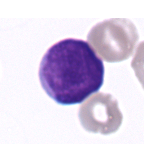

In [3]:
Image.open("../data/aml_data/NPM1/PBO_image_29.tif")

In [ ]:
# load_images from the google bucket


440.8602150537634

In [4]:
# did not work because image_dataset from directory not work with tif images
# train_dir= "../data/aml_data/"
# test_dir="../data/aml_test"
# train_ds=image_dataset_from_directory(directory=train_dir,
#                                       labels="inferred",
#                                       image_size=(224,224),
#                                       color_mode="rgb",
#                                       seed=123,
#                                       subset="training",
#                                       validation_split=0.25)
# val_ds=image_dataset_from_directory(directory=test_dir,
#                                       labels="inferred",
#                                       image_size=(224,224),
#                                       color_mode="rgb",
#                                       seed=123,
#                                       subset="valdiation",
#                                       validation_split=0.25)
# test_ds=image_dataset_from_directory(directory=test_dir,
#                                       labels="inferred",
#                                       image_size=(224,224),
#                                       color_mode="rgb",
#                                       )

In [5]:
root_dir = '../data/aml_data'  # Folder containing subfolders per class
img_size = (144, 144)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Get class names and file paths
class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]) #foldernames==>>class_names
class_to_index = {name: idx for idx, name in enumerate(class_names)}

filepaths = []
labels = []

for class_name in class_names:
    class_path = os.path.join(root_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith('.tif'):
            filepaths.append(os.path.join(class_path, fname))
            labels.append(class_to_index[class_name])

# Convert to TensorFlow Dataset
paths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
full_ds = tf.data.Dataset.zip((paths_ds, labels_ds))

# Step 3: Define load function for .tif images
def load_tif(path, label):
    image_bytes = tf.io.read_file(path)
    image = tfio.experimental.image.decode_tiff(image_bytes)
    image = tf.image.resize(image, img_size)
    image = image[..., :3]
    image = tf.cast(image, tf.float32)
    return image, label

# Apply preprocessing
full_ds = full_ds.map(load_tif, num_parallel_calls=AUTOTUNE)

#Shuffle and split (70/20/10)
full_ds = full_ds.shuffle(buffer_size=len(filepaths))

train_size = int(0.7 * len(filepaths))
val_size = int(0.2 * len(filepaths))

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

# Batch and prefetch
def prep(ds):
    return ds.batch(batch_size).prefetch(AUTOTUNE)

train_ds = prep(train_ds)
val_ds = prep(val_ds)
test_ds = prep(test_ds)


In [ ]:
# for value in train_ds.take(1):
#     print(value)

In [6]:
from keras.applications import vgg16
from keras import layers, Sequential
vgg16_basemodel=vgg16.VGG16(include_top=False,
                  input_shape=(144,144,3),
                  weights="imagenet"
                  )
vgg16_basemodel.trainable=False

In [ ]:
# model.summary()

In [7]:

model=Sequential()
model.add(vgg16_basemodel)
model.add(layers.Flatten())
model.add(layers.Dense(250, activation="relu"))
model.add(layers.Dense(5,activation="softmax"))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │     2,048,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,764,193 (63.95 MB)

 Trainable params: 2,049,505 (7.82 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if one-hot encoded
    metrics=['accuracy']
)

In [10]:
model.fit(train_ds, epochs=1, batch_size=32,verbose=1, validation_data=val_ds)

2025-06-28 10:48:25.145413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 20153 of 81214
2025-06-28 10:48:35.077209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 23773 of 81214
2025-06-28 10:48:47.839620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1751100528.168357 11611019 service.cc:145] XLA service 0x30c4e14e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751100528.172428 11611019 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1751100528.783527 11611019 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1777/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4089 - loss: 3.2679

2025-06-28 13:47:23.002127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 19757 of 81214
2025-06-28 13:47:33.033041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 30157 of 81214
2025-06-28 13:47:52.970047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 78172 of 81214
2025-06-28 13:47:53.969020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1777/1777 ━━━━━━━━━━━━━━━━━━━━ 11595s 7s/step - accuracy: 0.4089 - loss: 3.2670 - val_accuracy: 0.5171 - val_loss: 1.1404


In [12]:
model.save("1epoch_40.keras")

In [13]:
model.save("1epoch_40.h5")

In [14]:
model.predict(test_ds)

2025-06-28 15:03:46.516069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 17813 of 81214
2025-06-28 15:03:56.679959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 23858 of 81214
2025-06-28 15:04:18.180728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 38931 of 81214
2025-06-28 15:04:36.405095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 78690 of 81214
2025-06-28 15:04:37.533996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


254/254 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step


array([[0.08694059, 0.18901879, 0.07220357, 0.09305423, 0.5587828 ],
       [0.15210992, 0.48358446, 0.07733191, 0.28589103, 0.00108278],
       [0.20382844, 0.3124339 , 0.18437263, 0.18476269, 0.11460225],
       ...,
       [0.2840035 , 0.11924561, 0.19803642, 0.38724405, 0.01147055],
       [0.02480627, 0.11192428, 0.01763451, 0.03346485, 0.81217015],
       [0.23430774, 0.20075296, 0.23772243, 0.1849265 , 0.14229044]],
      dtype=float32)

In [ ]:
import tensorflow as tf
from google.co